<a href="https://colab.research.google.com/github/uwituzeb/summative-intro-to-ml/blob/main/summative_Intro_to_ml_bernice_uwituze_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Pathway Finder**




In [35]:
# import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# **Project Name: Pathway Finder**

**Problem Statement**

In Rwanda, high school students face significant challenges due to an inadequate career guidance system. This issue has led to limited career exploration, with students not being able to follow their passions because they are often not aware of what career options are available.

**Data**

The dataset used is sourced from Kaggle although it was initially directed to university students, the data was pre-processed to cater to high school students. The data contains about 1000 rows of data and 10 columns of data which are candidateId, age, education, gpa, interest, favorite subject, extracurriculars, personality trait and recommended career which is our target.

In [36]:
#load dataset
path = "high_school_career_recommendation_dataset.csv"
df = pd.read_csv(path)
df.head()




,CandidateID,Age,Education,GPA,Interest,Favorite_Subject,Extracurriculars,Personality_Trait,Recommended_Career
0,1,16,O-Level,3.51,Business,Economics,Drama Club,Analytical,Financial Analyst
1,2,17,A-Level,3.52,Humanities,History,Environmental Club,Leader,Lawyer
2,3,16,O-Level,2.85,Business,Physical Education,Debate Team,Leader,Business Manager
3,4,17,A-Level,3.53,Humanities,History,Math Team,Analytical,Software Engineer
4,5,14,O-Level,3.00,Humanities,English,Math Team,Social,Journalist


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Split data into features and target
X = df.drop('Recommended_Career', axis=1)
y = df['Recommended_Career']

# One-hot encoding for categorical features
X = pd.get_dummies(X, columns=['Education', 'Interest', 'Favorite_Subject',
                       'Extracurriculars', 'Personality_Trait'])

# Splitting into train and test
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

#Second split to get validation and test data
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Scaling features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

print('Training data shape', x_train_scaled.shape)
print('Validation data shape', x_val_scaled.shape)
print('Test data shape', x_test_scaled.shape)

Training data shape (600, 51)
Validation data shape (200, 51)
Test data shape (200, 51)


#SECTION 1: Model Architecture:


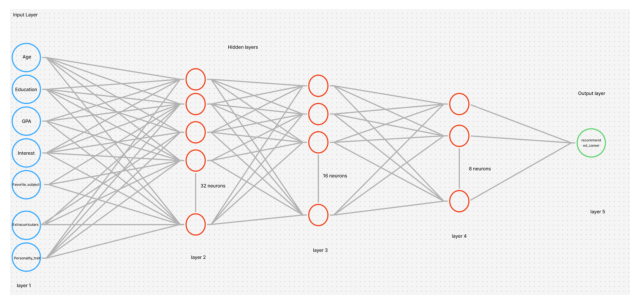

In [39]:
from PIL import ImageChops
import matplotlib.image as mpimg

img = mpimg.imread('model_architecture.png')

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#Task: Define a function that creates models without and With specified Optimization techniques


In [45]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


def define_model(optimization: str='default', regularization_type=None, early_stopping: bool=False, dropout: float=0.0, learning_rate: float=0.001, epochs=100, batch_size=32):
  model= Sequential()
  input_shape = x_train_scaled.shape[1]
  num_classes = len(label_encoder.classes_)

  # Regularization configuration
  regularization = None
  if regularization_type == 'l1':
    regularization = l1(0.01)
  elif regularization_type == 'l2':
    regularization = l2(0.01)
  elif regularization_type == 'l1_l2':
    regularization = l1_l2(l1=0.01, l2=0.01)

  # Optimizer configuration
  optimizer = None
  if optimization == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimization == 'rmsprop':
    optimizer = RMSprop(learning_rate=learning_rate)
  elif optimization == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)
  else:
    optimizer = Adam()

  # Model architecture

  model.add(Dense(32, activation="relu", input_shape=(input_shape,), kernel_regularizer=regularization))
  model.add(BatchNormalization())
  if dropout > 0:
    model.add(Dropout(dropout))

  # Hidden layers
  model.add(Dense(16, activation="relu", kernel_regularizer=regularization))
  model.add(BatchNormalization())
  if dropout > 0:
    model.add(Dropout(dropout))

  model.add(Dense(8, activation="relu", kernel_regularizer=regularization))
  model.add(BatchNormalization())
  if dropout > 0:
    model.add(Dropout(dropout))

  # Output layer
  model.add(Dense(num_classes, activation="softmax"))

  # Configure callbacks
  callbacks = []
  if early_stopping:
    callbacks.append(EarlyStopping(monitor="val_loss",patience=10, restore_best_weights=True))

  # Compile the model
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

  history = model.fit(
      x_train_scaled, y_train,
      validation_data=(x_val_scaled, y_val),
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      callbacks=callbacks

  )
  return model, history

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [46]:
def loss_curve_plot(history):
  #Extract training and validation loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history.get('accuracy')
  val_accuracy = history.history.get('val_accuracy')

  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'b-', label='Training loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
  print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")





# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.0406 - loss: 3.2759 - val_accuracy: 0.0600 - val_loss: 2.9965
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0706 - loss: 3.0636 - val_accuracy: 0.1150 - val_loss: 2.9361
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1031 - loss: 2.8811 - val_accuracy: 0.1650 - val_loss: 2.8676
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1403 - loss: 2.7689 - val_accuracy: 0.1950 - val_loss: 2.7886
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1891 - loss: 2.6665 - val_accuracy: 0.2550 - val_loss: 2.7030
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2871 - loss: 2.5454 - val_accuracy: 0.3600 - val_loss: 2.6151
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3039 - loss: 2.4328 - val_accuracy: 0.4050 - val_loss: 2.5095
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3782 - loss: 2.3544 - val_accuracy: 0.

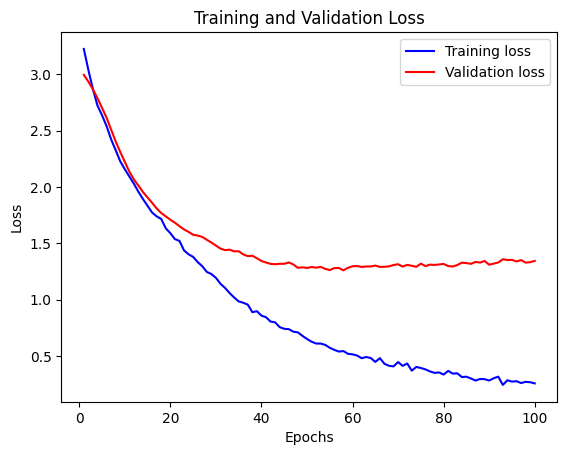

Training Accuracy: 0.9317
Validation Accuracy: 0.6250
Train: 0.965, Test: 0.560
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.67      1.00      0.80         6
           2       0.00      0.00      0.00         4
           3       0.88      0.37      0.52        19
           4       0.00      0.00      0.00         1
           5       0.50      0.40      0.44        10
           6       0.33      0.29      0.31         7
           7       0.57      0.44      0.50         9
           8       0.30      0.50      0.38        12
           9       0.80      0.67      0.73         6
          10       0.67      0.47      0.55        17
          11       0.43      0.50      0.46         6
          12       0.58      0.70      0.64        10
          13       0.57      1.00      0.73         4
          14       0.00      0.00      0.00         0
          15       0.75      0.19      0.30        16
          16       0.67      0.82      0.73        22
          17       0.29    

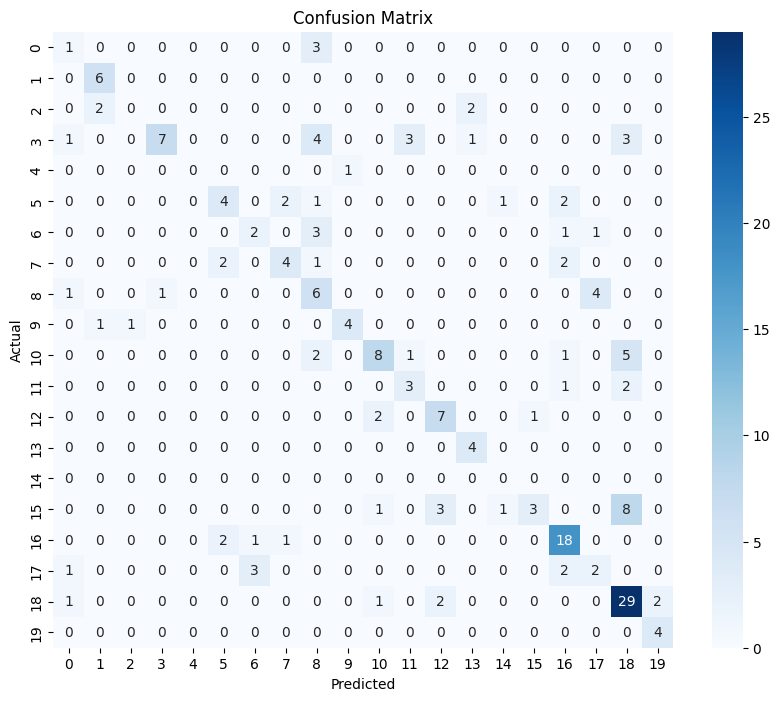

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import os

#default model

model_1, history_1 = define_model()
loss_curve_plot(history_1)

# Evaluate the model

_, train_acc = model_1.evaluate(x_train_scaled, y_train, verbose=0)
_, test_acc = model_1.evaluate(x_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_prob = model_1.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_multiclass = np.argmax(y_test, axis=1)
print(classification_report(y_test_multiclass, y_pred))

model_1.save('saved_models/default_model.h5')


#confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0381 - loss: 4.0875 - val_accuracy: 0.1250 - val_loss: 3.6694
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0624 - loss: 3.9628 - val_accuracy: 0.1750 - val_loss: 3.6062
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0923 - loss: 3.7660 - val_accuracy: 0.2000 - val_loss: 3.5478
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0862 - loss: 3.6954 - val_accuracy: 0.2300 - val_loss: 3.4860
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1405 - loss: 3.5861 - val_accuracy: 0.2700 - val_loss: 3.4253
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1552 - loss: 3.4535 - val_accuracy: 0.2750 - val_loss: 3.3655
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2081 - loss: 3.3752 - val_accuracy: 0.2950 - val_loss: 3.3032
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1560 - loss: 3.3740 - val_accuracy: 0

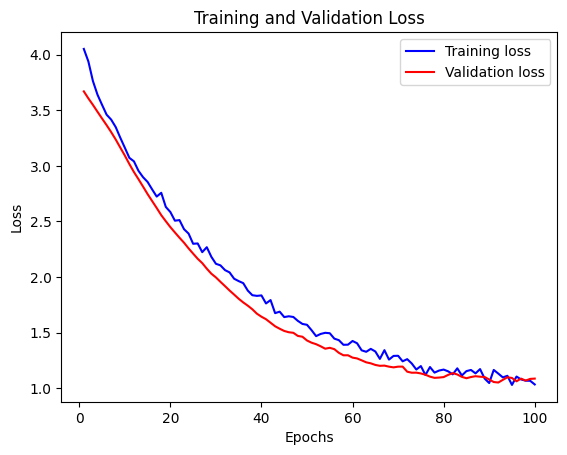

Training Accuracy: 0.6833
Validation Accuracy: 0.6900
Train: 0.830, Test: 0.640
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.55      1.00      0.71         6
           2       0.00      0.00      0.00         4
           3       0.75      0.47      0.58        19
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.41      0.78      0.54         9
           8       0.53      0.83      0.65        12
           9       1.00      0.50      0.67         6
          10       0.81      0.76      0.79        17
          11       0.57      0.67      0.62         6
          12       0.67      0.80      0.73        10
          13       0.67      1.00      0.80         4
          14       0.00      0.00      0.00         0
          15       1.00      0.31      0.48        16
          16       0.75      0.82      0.78        22
          17       0.36    

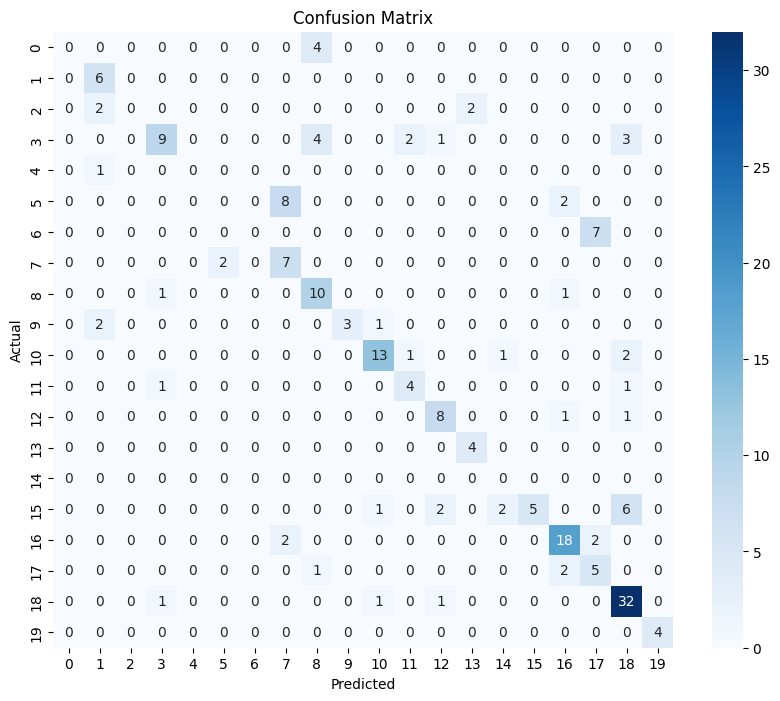

In [ ]:
model_2, history_2 = define_model(
    optimization='adam',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.2,

)
loss_curve_plot(history_2)
#print out confusion matrix and error analysis metrics after the cell
# Evaluate the model
_, train_acc = model_2.evaluate(x_train_scaled, y_train, verbose=0)
_, test_acc = model_2.evaluate(x_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_prob = model_2.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)
print(classification_report(y_test_multiclass, y_pred))

model_2.save('saved_models/l2_adam_model.h5')


#confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.0619 - loss: 6.7561 - val_accuracy: 0.0550 - val_loss: 6.3999
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0441 - loss: 6.4955 - val_accuracy: 0.0700 - val_loss: 6.2303
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0727 - loss: 6.2764 - val_accuracy: 0.1000 - val_loss: 6.0662
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1220 - loss: 6.1384 - val_accuracy: 0.1800 - val_loss: 5.8991
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1434 - loss: 5.8513 - val_accuracy: 0.2600 - val_loss: 5.7359
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1844 - loss: 5.7451 - val_accuracy: 0.3250 - val_loss: 5.5760
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2132 - loss: 5.5681 - val_accuracy: 0.3350 - val_loss: 5.4186
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2486 - loss: 5.3915 - val_accuracy: 0.

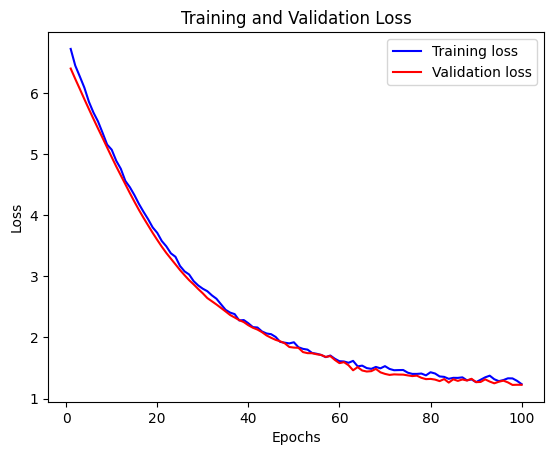

Training Accuracy: 0.6917
Validation Accuracy: 0.6850
Train: 0.775, Test: 0.630
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.55      1.00      0.71         6
           2       0.00      0.00      0.00         4
           3       0.92      0.58      0.71        19
           4       0.00      0.00      0.00         1
           5       0.50      0.10      0.17        10
           6       0.00      0.00      0.00         7
           7       0.58      0.78      0.67         9
           8       0.50      0.92      0.65        12
           9       0.40      0.33      0.36         6
          10       0.71      0.59      0.65        17
          11       0.45      0.83      0.59         6
          12       0.70      0.70      0.70        10
          13       0.60      0.75      0.67         4
          14       0.00      0.00      0.00         0
          15       1.00      0.31      0.48        16
          16       0.72      0.82      0.77        22
          17       0.33    

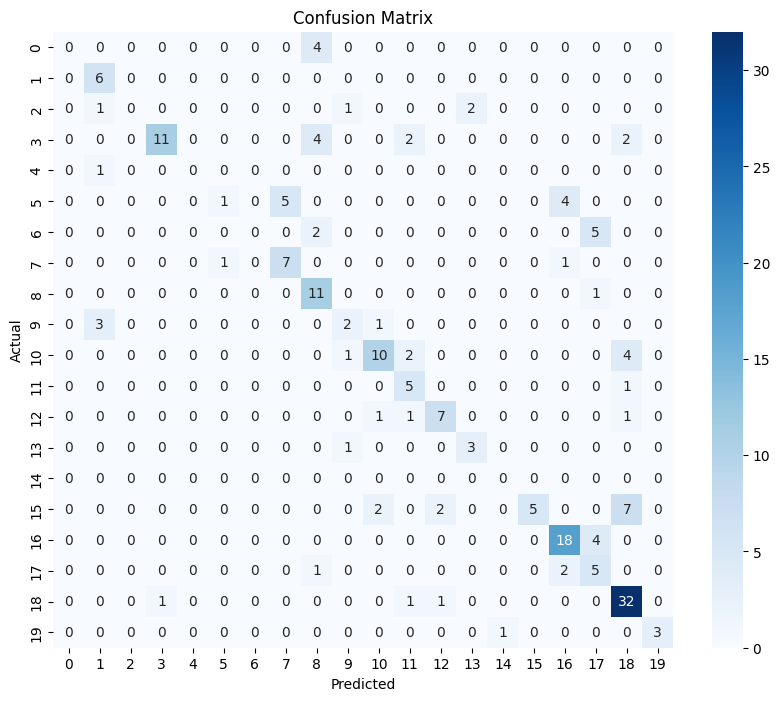

In [24]:
model_3, history_3 = define_model(
    optimization='adam',
    regularization_type='l1',
    early_stopping=True,
    dropout=0.2,
)
loss_curve_plot(history_3)
#print out confusion matrix and error analysis metrics after the cell
# Evaluate the model
_, train_acc = model_3.evaluate(x_train_scaled, y_train, verbose=0)
_, test_acc = model_3.evaluate(x_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_prob = model_3.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)
print(classification_report(y_test_multiclass, y_pred))

model_3.save('saved_models/l1_adam_model.h5')


#confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.0421 - loss: 3.9449 - val_accuracy: 0.0500 - val_loss: 3.6869
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0759 - loss: 3.8519 - val_accuracy: 0.0600 - val_loss: 3.6382
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0702 - loss: 3.7766 - val_accuracy: 0.0900 - val_loss: 3.5912
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0797 - loss: 3.6941 - val_accuracy: 0.1150 - val_loss: 3.5419
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0933 - loss: 3.5901 - val_accuracy: 0.1850 - val_loss: 3.4931
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1136 - loss: 3.5300 - val_accuracy: 0.2150 - val_loss: 3.4434
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1492 - loss: 3.4348 - val_accuracy: 0.2400 - val_loss: 3.3908
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1156 - loss: 3.4338 - val_accuracy: 0.

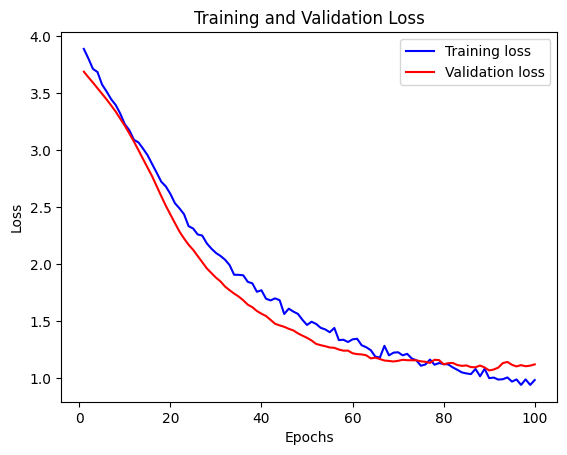

Training Accuracy: 0.6800
Validation Accuracy: 0.6700
Train: 0.860, Test: 0.630
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60      1.00      0.75         6
           2       0.67      0.50      0.57         4
           3       0.79      0.58      0.67        19
           4       0.00      0.00      0.00         1
           5       0.33      0.20      0.25        10
           6       0.50      0.29      0.36         7
           7       0.38      0.56      0.45         9
           8       0.47      0.75      0.58        12
           9       1.00      0.67      0.80         6
          10       0.86      0.71      0.77        17
          11       0.62      0.83      0.71         6
          12       0.50      0.80      0.62        10
          13       0.75      0.75      0.75         4
          14       0.00      0.00      0.00         0
          15       0.75      0.19      0.30        16
          16       0.83      0.86      0.84        22
          17       0.38    

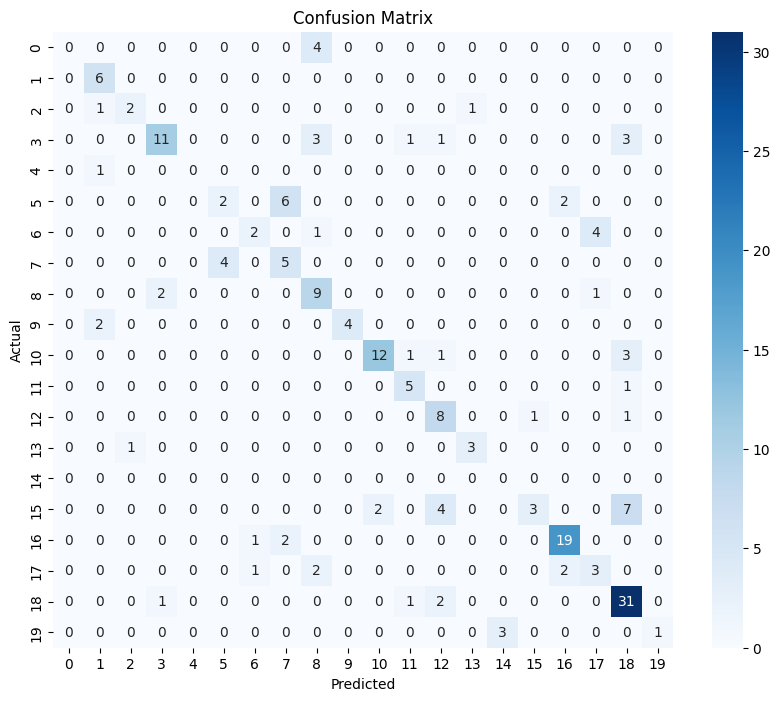

In [25]:

model_4, history_4 = define_model(
    optimization='SGD',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.2,
)
loss_curve_plot(history_4)
#print out confusion matrix and error analysis metrics after the cell
# Evaluate the model
_, train_acc = model_4.evaluate(x_train_scaled, y_train, verbose=0)
_, test_acc = model_4.evaluate(x_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_prob = model_4.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)
print(classification_report(y_test_multiclass, y_pred))

model_4.save('saved_models/l2_SGD_model.h5')


#confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0375 - loss: 7.4102 - val_accuracy: 0.0850 - val_loss: 6.8895
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0463 - loss: 7.0255 - val_accuracy: 0.1000 - val_loss: 6.6936
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0724 - loss: 6.7657 - val_accuracy: 0.1300 - val_loss: 6.4898
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0812 - loss: 6.5307 - val_accuracy: 0.2100 - val_loss: 6.2740
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1420 - loss: 6.2327 - val_accuracy: 0.2300 - val_loss: 6.0509
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1437 - loss: 6.0300 - val_accuracy: 0.2550 - val_loss: 5.8343
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1978 - loss: 5.8020 - val_accuracy: 0.2700 - val_loss: 5.6137
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2266 - loss: 5.5382 - val_accuracy: 0.

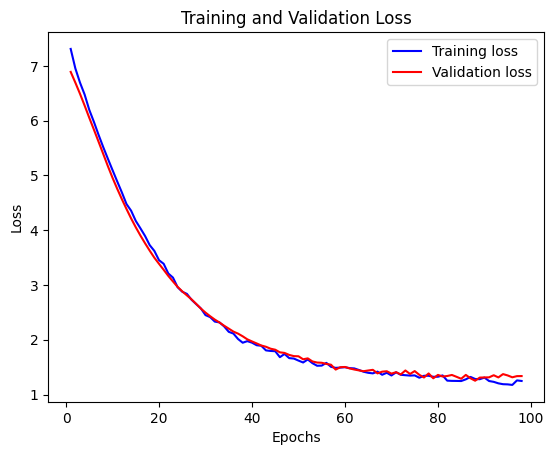

Training Accuracy: 0.6800
Validation Accuracy: 0.6500
Train: 0.788, Test: 0.650
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60      1.00      0.75         6
           2       0.00      0.00      0.00         4
           3       0.75      0.63      0.69        19
           4       0.00      0.00      0.00         1
           5       0.29      0.20      0.24        10
           6       0.33      0.14      0.20         7
           7       0.38      0.33      0.35         9
           8       0.59      0.83      0.69        12
           9       1.00      0.67      0.80         6
          10       0.75      0.71      0.73        17
          11       0.50      0.83      0.62         6
          12       0.62      0.80      0.70        10
          13       0.67      1.00      0.80         4
          14       0.00      0.00      0.00         0
          15     

c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

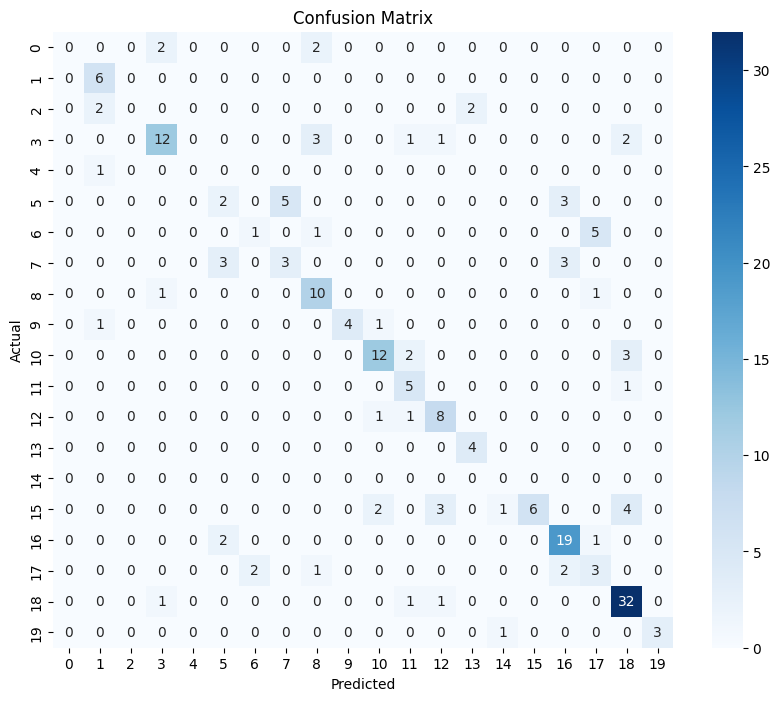

In [26]:
model_5, history_5 = define_model(
    optimization='RMSprop',
    regularization_type='l1_l2',
    early_stopping=True,
    dropout=0.2,
)
loss_curve_plot(history_5)
#print out confusion matrix and error analysis metrics after the cell
# Evaluate the model
_, train_acc = model_5.evaluate(x_train_scaled, y_train, verbose=0)
_, test_acc = model_5.evaluate(x_test_scaled, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_prob = model_5.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)
print(classification_report(y_test_multiclass, y_pred))

model_5.save('saved_models/default_model.h5')


#confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [28]:
# logistic regression
from sklearn.linear_model import LogisticRegression
import joblib

logistic_model = LogisticRegression(
    multi_class='multinomial', #for multiclass classification
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

logistic_model.fit(x_train_scaled, y_train_encoded)
joblib.dump(logistic_model, 'saved_models/logistic_regression_model.pkl')

y_pred_train = logistic_model.predict(x_train_scaled)
y_pred_test = logistic_model.predict(x_test_scaled)

#Evaluate model
print(classification_report(y_train_encoded, y_pred_train, target_names=label_encoder.classes_))
print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder.classes_))




c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                         precision    recall  f1-score   support

             Accountant       1.00      1.00      1.00         6
              Architect       0.84      0.87      0.86        31
                 Artist       0.78      0.70      0.74        20
       Business Manager       1.00      0.97      0.98        31
                   Chef       1.00      1.00      1.00         1
                 Doctor       0.79      0.73      0.76        15
               Engineer       0.82      0.78      0.80        18
Environmental Scientist       0.82      0.86      0.84        21
      Financial Analyst       0.91      0.94      0.93        33
       Graphic Designer       0.90      0.93      0.92        29
             Journalist       0.97      0.92      0.94        36
                 Lawyer       0.96      0.96      0.96        25
   Marketing Specialist       1.00      0.95      0.97        40
               Musician       1.00      1.00      1.00        24
                  Nurse 

c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HOSA.LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [33]:
def make_predictions(model_path, X):

    # Load the model
    model = joblib.load(model_path)
    # Make predictions
    predictions = model.predict(X)
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [34]:
model_path = 'saved_models/logistic_regression_model.pkl'
make_predictions(model_path, x_test_scaled)

array([12, 16,  2,  7, 16, 18, 16, 16, 10, 16, 12, 15, 18,  1,  5, 16, 18,
       18,  3, 18, 18, 18, 13,  3, 17,  1,  8,  3, 18, 17,  9, 15, 18, 16,
       16, 18, 10, 16, 18,  8, 15, 18, 13, 18,  7, 18,  3, 18, 17, 18, 18,
        8, 16, 10, 18, 12,  7, 12, 10, 10, 16,  1, 18,  7,  8,  6,  1, 12,
       18, 10, 18, 10,  5,  2, 16,  8,  3, 18, 16,  7, 18, 13, 15,  9,  8,
       11, 18,  5, 17, 16,  1, 10,  3,  3,  3,  3, 12,  8, 16, 12,  6, 15,
       10,  7,  8,  5, 17, 18,  7,  5,  9, 18, 18,  8,  7, 18, 18, 16,  6,
       18, 16, 12,  8,  3, 18, 17, 12, 16,  7, 18, 10,  8,  3,  3,  1,  9,
       18,  8, 14, 14, 18, 18, 16,  2,  3, 10,  6,  5,  3, 16,  9,  7, 18,
        8, 18, 18,  3, 10, 19, 11, 16, 18, 15, 19, 11, 19,  9,  8, 18, 18,
       15,  7, 16, 10, 13, 17, 19,  8,  9, 18, 18, 13,  8,  6, 10, 16,  0,
        5, 10, 18, 17, 18,  3, 10, 16, 12, 18, 18,  8,  3])

Congratulations!!
